<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Subsampling-tree" data-toc-modified-id="Subsampling-tree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Subsampling tree</a></span></li><li><span><a href="#Creating-datasets" data-toc-modified-id="Creating-datasets-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Creating datasets</a></span></li><li><span><a href="#parafit:-just-global-test" data-toc-modified-id="parafit:-just-global-test-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>parafit: just global test</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Summarizing" data-toc-modified-id="Summarizing-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Summarizing</a></span></li></ul></li><li><span><a href="#parafit:-individual-links" data-toc-modified-id="parafit:-individual-links-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>parafit: individual links</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Summarizing" data-toc-modified-id="Summarizing-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Summarizing</a></span></li><li><span><a href="#Links-per-host" data-toc-modified-id="Links-per-host-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Links per host</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>sessionInfo</a></span></li><li><span><a href="#Sandbox" data-toc-modified-id="Sandbox-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sandbox</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#notes" data-toc-modified-id="notes-9.0.0.1"><span class="toc-item-num">9.0.0.1&nbsp;&nbsp;</span>notes</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Goal

* Run `ape::parafit()` analysis on IndD dataset summed by host
* Sensitivity analysis (species-level): selecting one sample per species

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/parafit/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# host phylogeny
host_tree_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD.nwk'

# misc
sparsity_cutoff = 0.05
threads = 12

# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)
library(ape)

library(future)
library(future.batchtools)
library(future.apply)

source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 
source('/ebio/abt3_projects/Georg_animal_feces/code/itol.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘future.apply’

The following object is masked from ‘package:future’:

    future_lapply



In [3]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/parafit/ 


In [4]:
rescale_dist_mtx = function(m){
    m = m %>% as.matrix
    labs = m %>% colnames
    n_row = m %>% nrow
    n_col = m %>% ncol
    x = m %>% as.vector 
    x = scales::rescale(x) 
    m = matrix(x, nrow=n_row, ncol=n_col)
    colnames(m) = labs
    rownames(m) = labs
    m = m %>% as.dist
    return(m)
}

# Load

In [5]:
physeq = readRDS(physeq_file) %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [6]:
metadata = physeq %>%
    sample_data %>%
    dplyr::select(scientific_name) %>%
    mutate(SampleID = rownames(.)) %>%
    as.data.frame

rownames(metadata) = metadata$SampleID
metadata %>% dfhead

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

[1] 213   2


,scientific_name,SampleID
X1.Eurasian.Beaver,Castor_fiber,X1.Eurasian.Beaver
X101.Horse,Equus_caballus,X101.Horse
X102.Kulan,Equus_hemionus,X102.Kulan


In [7]:
host_tree = read.tree(host_tree_file)
host_tree


Phylogenetic tree with 213 tips and 177 internal nodes.

Tip labels:
	X256.Zander, F302.Northern.Pike, X188.Brook.Trout, F300.Asp, X330.Ide, X327.Silver.Bream, ...
Node labels:
	Node1, Node2, Node3, Node4, Node5, Node6, ...

Rooted; includes branch lengths.

# Subsampling tree

In [8]:
# number of subsampled trees
ntrees = 100

In [9]:
#' randomly selecting one per group
tree_subsample = function(L, df, tree){
    # get subsample (note: subsampling within each species)
    to_keep = df %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$sample
    # subsampling tree
    to_rm = setdiff(tree$tip.label, to_keep)
    tree = drop.tip(tree, to_rm)
    return(tree)
}

In [10]:
# subsampling trees
df = metadata %>%
    mutate(sample = rownames(.)) %>%
    dplyr::select(sample, scientific_name) 

doParallel::registerDoParallel(threads)
host_tree_l = plyr::llply(as.list(1:ntrees), 
                          function(x) tree_subsample(x, df, host_tree),
                          .parallel=TRUE)

# tree lengths
host_tree_l %>% length %>% print
lapply(host_tree_l, function(x) x$tip.label %>% length) %>% unlist %>% summary

[1] 100


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    128     128     128     128     128     128 

In [11]:
# checking overlap of labels
setdiff(host_tree_l[[1]]$tip.label, rownames(metadata)) %>% length %>% print

[1] 0


# Creating datasets

In [12]:
make_parafit_input = function(host_tree, physeq){
    # subsampled phyloseq object
    physeq_f = prune_samples(sample_names(physeq) %in% host_tree$tip.label, 
                             physeq) 

    # microbial tree distance matrix
    micro_D = physeq_f %>%
        phy_tree %>% cophenetic %>% 
        rescale_dist_mtx %>% as.matrix
    # host tree distance matrix
    host_D = host_tree %>% cophenetic %>% 
             rescale_dist_mtx %>% as.matrix
    
    # otu pres/abs matrix
    otu = physeq_f %>% 
        otu_table %>%
        as.data.frame %>%
        as.matrix %>%
        t %>%
        apply(2, function(x) ifelse(x > 0, 1, 0)) %>% 
        as.matrix                
              
              
    # checking overlap
    x = length(intersect(rownames(otu), rownames(host_D)))
    y = length(union(rownames(otu), rownames(host_D)))
    stopifnot(x == y)
              
    # preparing paco data
    return(list(host.D=host_D, para.D = micro_D, HP=otu))
}

In [13]:
# creating list of parafit input objects
doParallel::registerDoParallel(threads)
PF_l = plyr::llply(host_tree_l, make_parafit_input, physeq=physeq, .parallel=TRUE)
PF_l %>% length

[1] 100

# parafit: just global test

In [68]:
# cluster resources
resources = list(h_rt = '00:59:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_eco', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3_gt4.4/bin")
plan(batchtools_sge, resources=resources)

In [69]:
# Running parafit on each subsample
## WARNING: SLOW!
parafit_each = function(L, nperm=99, seed=3843, correction="cailliez", test.links=TRUE){
    parafit(L$host.D, L$para.D, L$HP, 
            nperm=nperm, 
            seed=seed,
            correction=correction,
            test.links=test.links)
}

PF_res_l = future_lapply(PF_l, parafit_each, 
                         nperm=999, 
                         test.links=FALSE,
                         future.packages=c('ape'))

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

In [70]:
# results
PF_res_l %>% length

[1] 100

## Saving results

In [128]:
# for loading results instead of re-running
PF_file = file.path(work_dir, 'physeq_IndD-sens_parafit.RDS')
PF_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/parafit//physeq_IndD-sens_parafit.RDS"

In [74]:
# saving
saveRDS(PF_res_l, file=PF_file)
cat('File written:', PF_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/parafit//physeq_IndD-sens_parafit.RDS 


In [129]:
# re-loading
PF_res_l = readRDS(PF_file)
PF_res_l %>% length

[1] 100

## Summarizing

In [130]:
# distribution of effect size
lapply(PF_res_l, function(x) x$ParaFitGlobal) %>% unlist %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  601.3   741.8   800.9   809.5   876.5  1100.0 


In [131]:
# distribution of p-values
lapply(PF_res_l, function(x) x$p.global) %>% unlist %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.001   0.001   0.001   0.001   0.001   0.001 


In [72]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/parafit/01_IndD-sens.ipynb')

# parafit: individual links

In [96]:
# cluster resources
resources = list(h_rt = '200:00:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_eco', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3_gt4.4/bin")
plan(batchtools_sge, resources=resources)

In [ ]:
# Running parafit on each subsample
## WARNING: SLOW!
parafit_each = function(L, nperm=99, seed=3843, correction="cailliez", test.links=TRUE){
    parafit(L$host.D, L$para.D, L$HP, 
            nperm=nperm, 
            seed=seed,
            correction=correction,
            test.links=test.links)
}

PF_res_links_l = future_lapply(PF_l, parafit_each, 
                         nperm=999, 
                         test.links=TRUE,
                         future.packages=c('ape'))

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

In [ ]:
# results
PF_res_links_l %>% length

## Saving results

In [133]:
# for loading results instead of re-running
PF_file = file.path(work_dir, 'physeq_IndD-sens_parafit-links.RDS')
PF_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/host_specific/parafit//physeq_IndD-sens_parafit-links.RDS"

In [84]:
# saving
saveRDS(PF_res_links_l, file=PF_file)
cat('File written:', PF_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/parafit//physeq_IndD-sens_parafit-links.RDS 


In [134]:
# re-loading
PF_res_links_l = readRDS(PF_file)
PF_res_links_l %>% length

[1] 100

In [ ]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/parafit/01_IndD-sens.ipynb')

## Summarizing

In [135]:
# distribution of effect size
lapply(PF_res_links_l, function(x) x$ParaFitGlobal) %>% unlist %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  601.3   741.8   800.9   809.5   876.5  1100.0 

In [136]:
# distribution of p-values
lapply(PF_res_links_l, function(x) x$p.global) %>% unlist %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.001   0.001   0.001   0.001   0.001   0.001 

## Links per host

* distribution of links per host

In [144]:
# format
para_per_host = lapply(PF_res_links_l, function(x) x$para.per.host) %>%
    do.call(rbind, .) %>%
    as.data.frame %>%
    mutate(Dataset_rep = 1:nrow(.)) %>%
    gather(Sample, N_links, -Dataset_rep) 
               
para_per_host %>% dfhead

[1] 12800     3


Dataset_rep,Sample,N_links
1,X1.Eurasian.Beaver,2
2,X1.Eurasian.Beaver,2
3,X1.Eurasian.Beaver,2


In [145]:
# adding metadata
para_per_host = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    dplyr::select(X.SampleID, class, order, family, genus, scientific_name, diet) %>%
    inner_join(para_per_host, c('X.SampleID'='Sample')) 

para_per_host %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”Warning message:
“Column `X.SampleID`/`Sample` joining factor and character vector, coercing into character vector”

[1] 12800     9


X.SampleID,class,order,family,genus,scientific_name,diet,Dataset_rep,N_links
X1.Eurasian.Beaver,Mammalia,Rodentia,Castoridae,Castor,Castor_fiber,herbivore,1,2
X1.Eurasian.Beaver,Mammalia,Rodentia,Castoridae,Castor,Castor_fiber,herbivore,2,2
X1.Eurasian.Beaver,Mammalia,Rodentia,Castoridae,Castor,Castor_fiber,herbivore,3,2


In [146]:
# summarizing by species: check
para_per_host %>%
    group_by(scientific_name) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    .$n %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    100     100     100     100     100     100 


In [147]:
# summarizing by species
alpha=0.95

para_per_host = para_per_host %>%
    group_by(scientific_name, class, order, family, genus, diet) %>%
    summarize(min_n_links = min(N_links),
              q1_n_links = quantile(N_links, 0.25),
              mean_n_links = mean(N_links),
              median_n_links = median(N_links),
              q3_n_links = quantile(N_links, 0.75),
              max_n_links = max(N_links),
              sd_n_links = sd(N_links),
              CI_low = quantile(N_links, (1-alpha)/2),
              CI_high = quantile(N_links, alpha+((1-alpha)/2))) %>%
    ungroup() %>%
    mutate(scientific_name = scientific_name %>% reorder(-median_n_links))

para_per_host$CI_low %>% summary %>% print
para_per_host %>% dfhead

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   2.841   4.000  19.000 
[1] 128  15


scientific_name,class,order,family,genus,diet,min_n_links,q1_n_links,mean_n_links,median_n_links,q3_n_links,max_n_links,sd_n_links,CI_low,CI_high
Acrocephalus_scirpaceus,Aves,Passeriformes,Sylviidae,Acrocephalus,omnivore,4,6,12.81,7,8,82,19.289237,4,82
Aepyceros_melampus,Mammalia,Artiodactyla,Bovidae,Aepyceros,herbivore,5,7,19.81,8,17,82,25.922844,5,82
Anas_platyrhynchos,Aves,Anseriformes,Anatidae,Anas,omnivore,1,6,8.46,9,12,15,4.008627,1,15


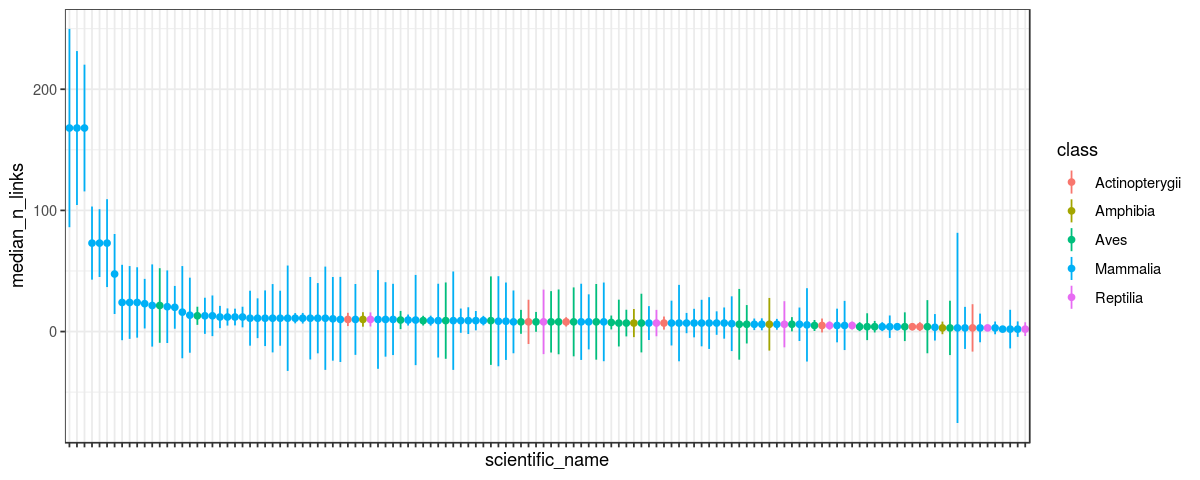

In [148]:
# plotting distribution
p = ggplot(para_per_host, aes(scientific_name, median_n_links, color=class)) +
    geom_linerange(aes(ymin=median_n_links-sd_n_links,
                       ymax=median_n_links+sd_n_links)) +
    geom_point() +
    theme_bw() +
    theme(
        axis.text.x = element_blank()
    )

options(repr.plot.width=10, repr.plot.height=4)
plot(p)

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/parafit/.figures/IndD-sens_parafit_nLinks-byClass.pdf 


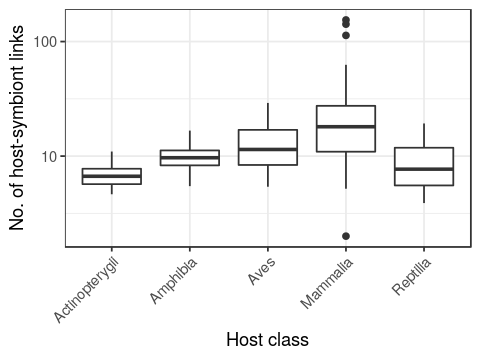

In [149]:
# plotting distribution
p = para_per_host %>%
    ggplot(aes(class, mean_n_links)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(x='Host class', y='No. of host-symbiont links') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=4, repr.plot.height=3)
plot_write(p, file='IndD-sens_parafit_nLinks-byClass.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/parafit/.figures/IndD-sens_parafit_nLinks-byClassDiet.pdf 


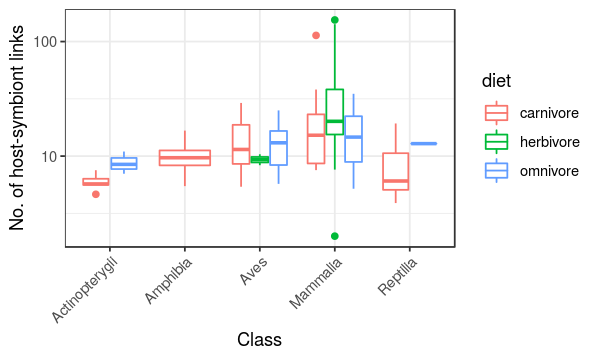

In [152]:
# plotting distribution
p = para_per_host %>%
    ggplot(aes(class, mean_n_links, color=diet)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(x='Class', y='No. of host-symbiont links') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=5, repr.plot.height=3)
plot_write(p, file='IndD-sens_parafit_nLinks-byClassDiet.pdf')

In [124]:
# # plotting distribution
# p = para_per_host %>%
#     filter(CI_low > 0,
#            class == 'Mammalia') %>%
#     mutate(scientific_name = scientific_name %>% reorder(median_n_links)) %>%
#     ggplot(aes(scientific_name, median_n_links, color=class)) +
#     geom_linerange(aes(ymin=median_n_links-sd_n_links,
#                        ymax=median_n_links+sd_n_links)) +
#     geom_point() +
#     labs(y='No. of links (95% CI)', x='Host') +
#     coord_flip() +
#     theme_bw() +
#     theme(
#         axis.text.y = element_text(size=8)
#     )

# options(repr.plot.width=6, repr.plot.height=7)
# plot(p)

In [125]:
# # plotting distribution
# p = para_per_host %>%
#     filter(CI_low > 0) %>%
#     mutate(scientific_name = scientific_name %>% reorder(CI_high)) %>%
#     ggplot(aes(scientific_name, median_n_links, color=class)) +
#     geom_linerange(aes(ymin=CI_low,
#                        ymax=CI_high)) +
#     geom_point(aes(y=CI_low), size=0.5) +
#     geom_point(aes(y=CI_high), size=0.5) +
#     labs(y='No. of links (95% CI)', x='Host') +
#     coord_flip() +
#     theme_bw() +
#     theme(
#         axis.text.y = element_text(size=8)
#     )

# options(repr.plot.width=6, repr.plot.height=11)
# plot(p)

In [126]:
# # plotting distribution
# p = para_per_host %>%
#     filter(CI_low > 0, 
#            class == 'Mammalia',
#            !is.na(CI_low)) %>%
#     mutate(scientific_name = scientific_name %>% reorder(CI_high)) %>%
#     ggplot(aes(scientific_name, median_n_links, color=order)) +
#     geom_linerange(aes(ymin=CI_low,
#                        ymax=CI_high)) +
#     geom_point(aes(y=CI_low), size=0.5) +
#     geom_point(aes(y=CI_high), size=0.5) +
#     labs(y='No. of links (95% CI)', x='Host') +
#     coord_flip() +
#     theme_bw() +
#     theme(
#         axis.text.y = element_text(size=8)
#     )

# options(repr.plot.width=6, repr.plot.height=8)
# plot(p)

# sessionInfo

In [49]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_eco/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_eco/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2.2          future.apply_1.0.0      future.batchtools_0.7.1
[4] future_1.8.1            ape_5.1                 phyloseq_1.22.3        
[7] ggplot2_3.0.0           tidyr_0.8.1 

***

# Sandbox

In [44]:
parafit_res = ape::parafit(parafit_l[[1]]$host.D,
             parafit_l[[1]]$para.D,
             parafit_l[[1]]$HP,
             nperm=99,
             correction="cailliez",
             test.links=TRUE)

parafit_res %>% length

n.hosts = 128 , n.parasites = 408 
Computation time = 45507.609000  sec 


[1] 6

In [45]:
parafit_res %>% summary

              Length Class  Mode   
ParaFitGlobal     1  -none- numeric
p.global          1  -none- numeric
link.table    15030  -none- numeric
para.per.host   128  -none- numeric
host.per.para   408  -none- numeric
nperm             1  -none- numeric

In [46]:
parafit_res$ParaFitGlobal

[1] 816.085

In [47]:
parafit_res$p.global

[1] 0.01

In [48]:
parafit_res$link.table %>% head

Host,Parasite,F1.stat,p.F1,F2.stat,p.F2
1,14,-5.0910155,1.00,-0.0121995780,1.00
1,235,2.7454659,0.01,0.0065789479,0.01
2,4,6.0176295,0.01,0.0144200190,0.01
2,27,-4.7906314,1.00,-0.0114797689,1.00
2,48,-0.3639119,0.75,-0.0008720405,0.89
2,51,0.2635628,0.45,0.0006315743,0.21


#### notes

* `F1` = ParaFit1.perm
* `F2` = ParaFit2.perm

From Legendre et al., 2002: 

> In summary, the ParaFitLink1 statistic gen- erally behaved better in simulations and
should be preferred to ParaFitLink2

In [50]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/parafit/01_IndD-sens.ipynb')